In [5]:
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
path="/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/Delhi_Brick_Kiln_Final_Mapped.csv"
df = pd.read_csv(path)
df.tail()

,Unnamed: 0,Lat,Lon,Year_Made,Year_Made_Category,Oval_FCB_to_ZigZag,Oval_FCB_to_ZigZag_Category,mapped_center_lat,mapped_center_lon
787,798,28.99870,77.44080,2009.0,category_2014,2018.0,category_2018,28.998692,77.440786
788,799,28.99912,77.44388,2009.0,category_2014,2018.0,category_2018,28.999140,77.443816
789,548,28.99956,77.24246,2009.0,category_2014,2019.0,category_2020,28.993040,77.242147
790,547,29.00273,77.23527,2009.0,category_2014,2019.0,category_2020,28.998799,77.226020
791,772,29.00273,77.23531,2009.0,category_2014,2019.0,category_2020,28.998799,77.226020


In [4]:
import pandas as pd

path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/Delhi_Brick_Kiln_Final_Mapped.csv"
df = pd.read_csv(path)

# remove 'category_' prefix from all string cells
df = df.applymap(
    lambda x: x.replace("category_", "") if isinstance(x, str) else x
)

df.tail()

,Unnamed: 0,Lat,Lon,Year_Made,Year_Made_Category,Oval_FCB_to_ZigZag,Oval_FCB_to_ZigZag_Category,mapped_center_lat,mapped_center_lon
787,798,28.99870,77.44080,2009.0,2014,2018.0,2018,28.998692,77.440786
788,799,28.99912,77.44388,2009.0,2014,2018.0,2018,28.999140,77.443816
789,548,28.99956,77.24246,2009.0,2014,2019.0,2020,28.993040,77.242147
790,547,29.00273,77.23527,2009.0,2014,2019.0,2020,28.998799,77.226020
791,772,29.00273,77.23531,2009.0,2014,2019.0,2020,28.998799,77.226020


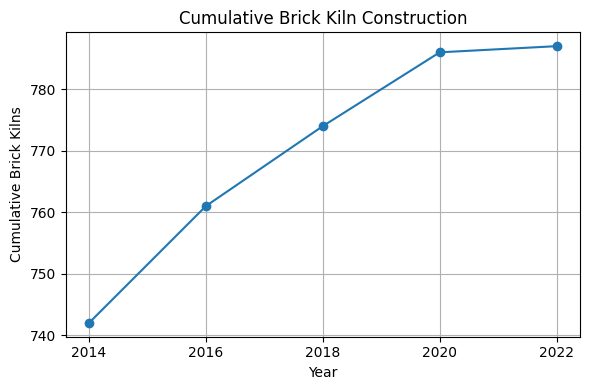

In [7]:
# count kilns per year category
counts = (
    df.groupby("Year_Made_Category")
      .size()
      .sort_index()
)

cum_counts = counts.cumsum()

plt.figure(figsize=(6,4))
plt.plot(cum_counts.index, cum_counts.values, marker="o")
plt.xlabel("Year")
plt.ylabel("Cumulative Brick Kilns")
plt.title("Cumulative Brick Kiln Construction")
plt.grid(True)
plt.tight_layout()
plt.show()

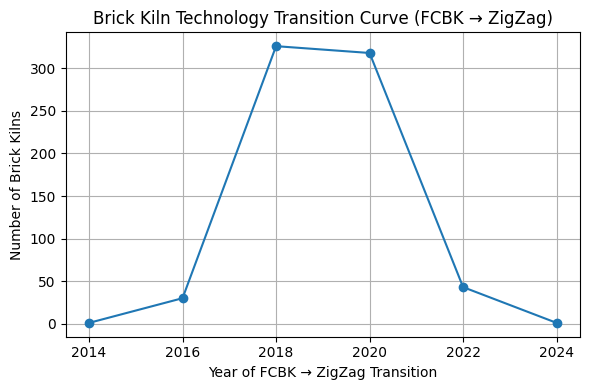

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/Delhi_Brick_Kiln_Final_Mapped.csv"
df = pd.read_csv(path)

# clean category strings if any remain
df["Oval_FCB_to_ZigZag_Category"] = (
    df["Oval_FCB_to_ZigZag_Category"]
    .astype(str)
    .str.replace("category_", "", regex=False)
)

# convert to numeric, drop missing
df["Oval_FCB_to_ZigZag_Category"] = pd.to_numeric(
    df["Oval_FCB_to_ZigZag_Category"], errors="coerce"
)

transitions = (
    df.dropna(subset=["Oval_FCB_to_ZigZag_Category"])
      .groupby("Oval_FCB_to_ZigZag_Category")
      .size()
      .sort_index()
)

# plot
plt.figure(figsize=(6,4))
plt.plot(transitions.index, transitions.values, marker="o")
plt.xlabel("Year of FCBK → ZigZag Transition")
plt.ylabel("Number of Brick Kilns")
plt.title("Brick Kiln Technology Transition Curve (FCBK → ZigZag)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
import pandas as pd

# input
in_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/vlm_kiln_appearance_results.csv"

# output
out_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/kilns_lat_lon_appearance_year.csv"

# -------------------------
# load
# -------------------------
df = pd.read_csv(in_path)

# -------------------------
# split lat_lon
# -------------------------
lat_lon_split = df["lat_lon"].str.split("_", expand=True)
df["lat"] = lat_lon_split[0].astype(float)
df["lon"] = lat_lon_split[1].astype(float)

# -------------------------
# keep only needed columns
# -------------------------
out_df = df[[
    "lat",
    "lon",
    "appearance_year",
    "confidence",
    "status"
]].copy()

# ensure numeric year
out_df["appearance_year"] = pd.to_numeric(
    out_df["appearance_year"], errors="coerce"
)

# -------------------------
# save
# -------------------------
out_df.to_csv(out_path, index=False)

print("Saved:", out_path)
print(out_df.tail(10))

Saved: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/kilns_lat_lon_appearance_year.csv
           lat        lon  appearance_year confidence status
743  28.994840  77.497136             2014       high     ok
744  28.995226  77.498505             2016       high     ok
745  28.995662  77.447145             2014       high     ok
746  28.995890  77.225858             2016       high     ok
747  28.996134  77.407910             2016       high     ok
748  28.997987  76.928070             2014       high     ok
749  28.998131  77.493241             2016       high     ok
750  28.998692  77.440786             2016       high     ok
751  28.998799  77.226020             2016       high     ok
752  28.999140  77.443816             2014       high     ok


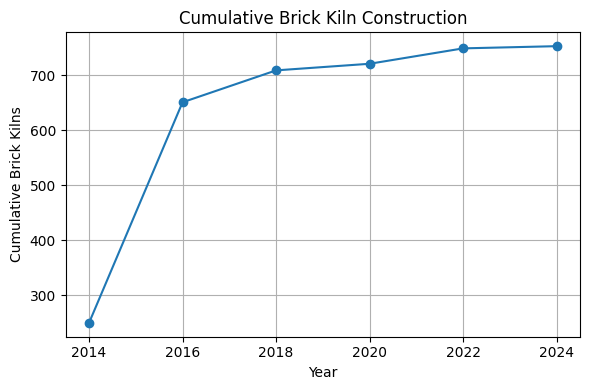

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# input: your VLM appearance CSV (lat, lon, appearance_year)
path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/kilns_lat_lon_appearance_year.csv"
df = pd.read_csv(path)

# numeric year, drop missing
df["appearance_year"] = pd.to_numeric(df["appearance_year"], errors="coerce")
df = df.dropna(subset=["appearance_year"])
df["appearance_year"] = df["appearance_year"].astype(int)

# choose the years to show (match your figure)
years = [2014, 2016, 2018, 2020, 2022, 2024]

# cumulative count: number of kilns with appearance_year <= y
cum_counts = [int((df["appearance_year"] <= y).sum()) for y in years]

plt.figure(figsize=(6,4))
plt.plot(years, cum_counts, marker="o")
plt.xlabel("Year")
plt.ylabel("Cumulative Brick Kilns")
plt.title("Cumulative Brick Kiln Construction")
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/Delhi_Brick_Kiln_Final_Mapped.csv"
df = pd.read_csv(path)

# remove category_ prefix if any remain
df = df.applymap(
    lambda x: x.replace("category_", "") if isinstance(x, str) else x
)

# ensure numeric year
df["Year_Made_Category"] = pd.to_numeric(
    df["Year_Made_Category"], errors="coerce"
)

# drop invalid rows
df = df.dropna(subset=["Year_Made_Category"])
df["Year_Made_Category"] = df["Year_Made_Category"].astype(int)
# choose the same reporting years you use elsewhere
years = [2014, 2016, 2018, 2020, 2022, 2024]

# cumulative count: kilns built on or before year y
cum_counts = [
    int((df["Year_Made_Category"] <= y).sum())
    for y in years
]


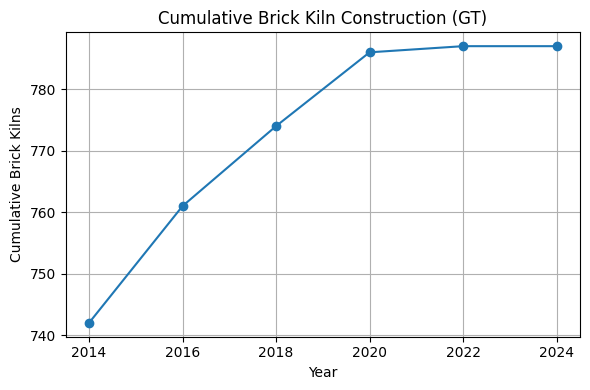

In [26]:
plt.figure(figsize=(6,4))
plt.plot(years, cum_counts, marker="o")
plt.xlabel("Year")
plt.ylabel("Cumulative Brick Kilns")
plt.title("Cumulative Brick Kiln Construction (GT)")
plt.grid(True)
plt.tight_layout()
plt.show()

Matched samples: 736
Saved merged pairs: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/gt_vlm_merged_for_confusion.csv


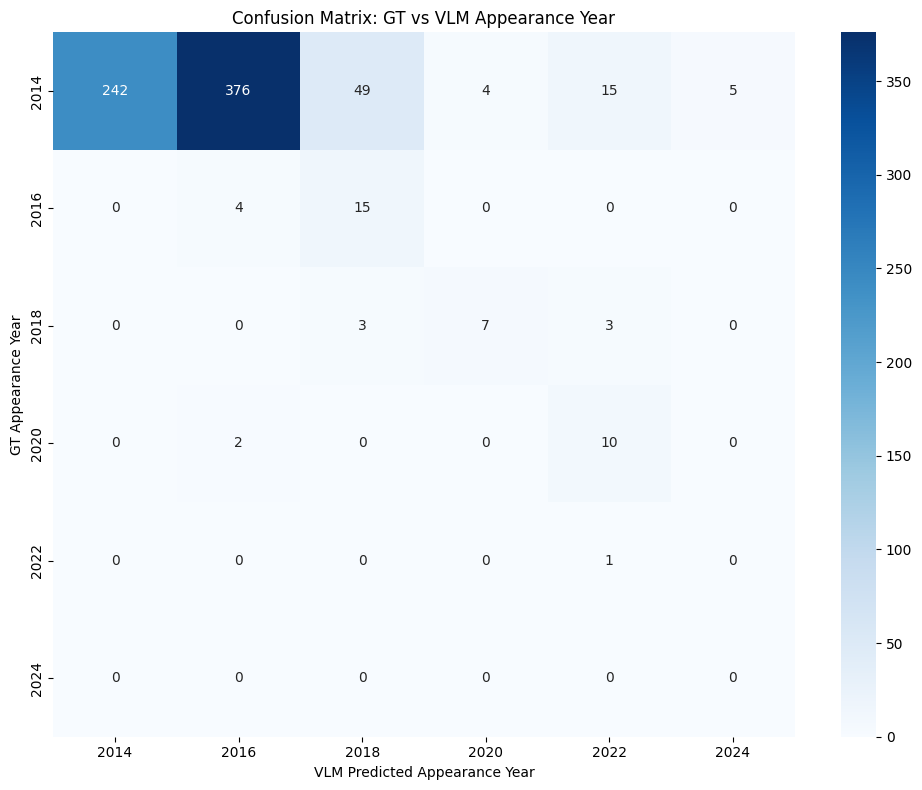

/tmp/ipykernel_2280538/236760458.py:129: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm / cm.sum(axis=1, keepdims=True)


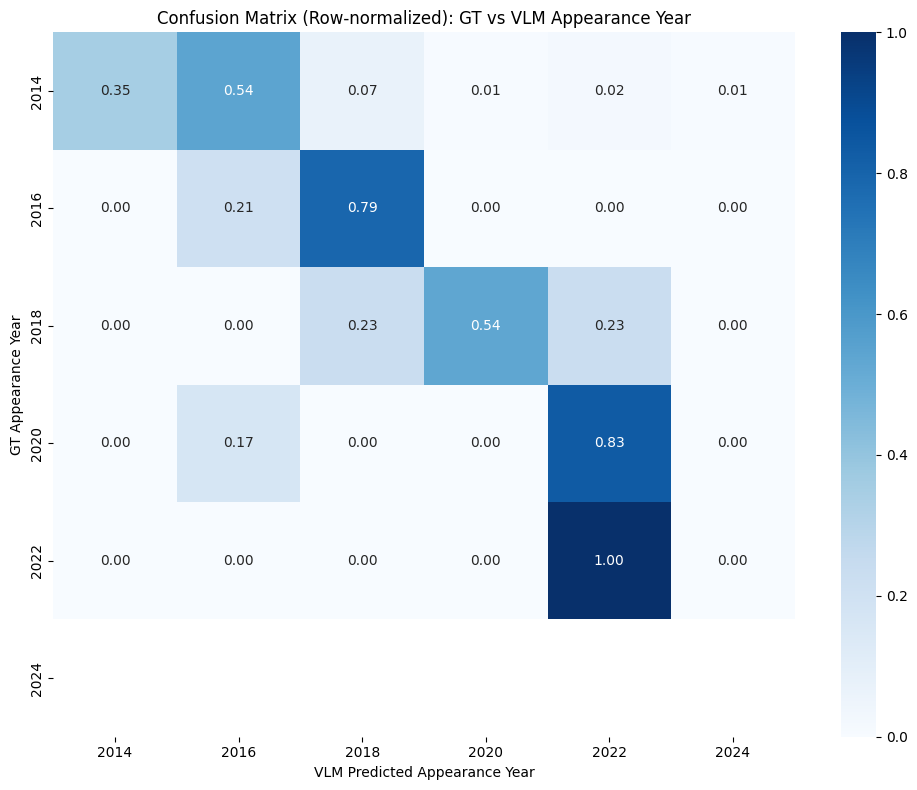

In [27]:
# End-to-end: GT vs VLM appearance-year confusion matrix
# Requires: pip install scikit-learn seaborn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

GT_PATH  = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/Delhi_Brick_Kiln_Final_Mapped.csv"
VLM_PATH = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/kilns_lat_lon_appearance_year.csv"

ROUND_DECIMALS = 6
DROP_NON_OK = True          # set False if you want to keep all VLM rows
DROP_NON_HIGH = False       # set True if you only want confidence == "high"

# -------------------------
# 1) Load
# -------------------------
gt = pd.read_csv(GT_PATH)
vlm = pd.read_csv(VLM_PATH)

# -------------------------
# 2) Clean GT: remove 'category_' prefix, cast year
# -------------------------
gt = gt.applymap(lambda x: x.replace("category_", "") if isinstance(x, str) else x)

gt["Year_Made_Category"] = pd.to_numeric(gt.get("Year_Made_Category"), errors="coerce")

# choose lat/lon columns for GT
if {"mapped_center_lat", "mapped_center_lon"}.issubset(gt.columns):
    gt_lat_col, gt_lon_col = "mapped_center_lat", "mapped_center_lon"
elif {"center_lat", "center_lon"}.issubset(gt.columns):
    gt_lat_col, gt_lon_col = "center_lat", "center_lon"
elif {"Lat", "Lon"}.issubset(gt.columns):
    gt_lat_col, gt_lon_col = "Lat", "Lon"
else:
    raise ValueError("GT file missing lat/lon columns. Expected mapped_center_lat/lon or center_lat/lon or Lat/Lon.")

gt[gt_lat_col] = pd.to_numeric(gt[gt_lat_col], errors="coerce")
gt[gt_lon_col] = pd.to_numeric(gt[gt_lon_col], errors="coerce")

gt["lat6"] = gt[gt_lat_col].round(ROUND_DECIMALS)
gt["lon6"] = gt[gt_lon_col].round(ROUND_DECIMALS)

# -------------------------
# 3) Clean VLM: parse lat_lon or use lat/lon columns, cast year
# -------------------------
if "appearance_year" not in vlm.columns:
    raise ValueError("VLM file must contain 'appearance_year' column.")

vlm["appearance_year"] = pd.to_numeric(vlm["appearance_year"], errors="coerce")

if DROP_NON_OK and "status" in vlm.columns:
    vlm = vlm[vlm["status"].astype(str).str.lower().eq("ok")]

if DROP_NON_HIGH and "confidence" in vlm.columns:
    vlm = vlm[vlm["confidence"].astype(str).str.lower().eq("high")]

if "lat_lon" in vlm.columns:
    tmp = vlm["lat_lon"].astype(str).str.split("_", expand=True)
    if tmp.shape[1] < 2:
        raise ValueError("VLM 'lat_lon' column does not look like 'lat_lon'.")
    vlm["lat"] = pd.to_numeric(tmp[0], errors="coerce")
    vlm["lon"] = pd.to_numeric(tmp[1], errors="coerce")
else:
    # fall back to existing columns
    if not {"lat", "lon"}.issubset(vlm.columns):
        raise ValueError("VLM file must contain either 'lat_lon' or both 'lat' and 'lon' columns.")

vlm["lat6"] = pd.to_numeric(vlm["lat"], errors="coerce").round(ROUND_DECIMALS)
vlm["lon6"] = pd.to_numeric(vlm["lon"], errors="coerce").round(ROUND_DECIMALS)

# -------------------------
# 4) Merge on rounded lat/lon
# -------------------------
merged = gt.merge(
    vlm,
    on=["lat6", "lon6"],
    how="inner",
    suffixes=("_gt", "_vlm")
)

# keep only valid year pairs
merged = merged.dropna(subset=["Year_Made_Category", "appearance_year"])
merged["Year_Made_Category"] = merged["Year_Made_Category"].astype(int)
merged["appearance_year"] = merged["appearance_year"].astype(int)

print("Matched samples:", len(merged))
if len(merged) == 0:
    raise RuntimeError("No matches found. Check rounding, columns, or whether both files cover same locations.")

# -------------------------
# 5) Confusion matrix (labels = union of years)
# -------------------------
labels = sorted(set(merged["Year_Made_Category"]).union(set(merged["appearance_year"])))

cm = confusion_matrix(
    merged["Year_Made_Category"],
    merged["appearance_year"],
    labels=labels
)

# save merged for audit
out_merged = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/gt_vlm_merged_for_confusion.csv"
merged.to_csv(out_merged, index=False)
print("Saved merged pairs:", out_merged)

# -------------------------
# 6) Plot
# -------------------------
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=labels,
    yticklabels=labels,
    cmap="Blues"
)
plt.xlabel("VLM Predicted Appearance Year")
plt.ylabel("GT Appearance Year")
plt.title("Confusion Matrix: GT vs VLM Appearance Year")
plt.tight_layout()
plt.show()

# -------------------------
# 7) Optional: normalized confusion matrix (row-normalized)
# -------------------------
cm_norm = cm / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    xticklabels=labels,
    yticklabels=labels,
    cmap="Blues"
)
plt.xlabel("VLM Predicted Appearance Year")
plt.ylabel("GT Appearance Year")
plt.title("Confusion Matrix (Row-normalized): GT vs VLM Appearance Year")
plt.tight_layout()
plt.show()

In [28]:
# Accuracy computation (end-to-end, continues from the merged dataframe logic)

import numpy as np
from sklearn.metrics import accuracy_score

# merged dataframe must already exist with:
# merged["Year_Made_Category"]  -> GT
# merged["appearance_year"]     -> VLM

y_true = merged["Year_Made_Category"].astype(int)
y_pred = merged["appearance_year"].astype(int)

# -------------------------
# 1) Exact-match accuracy
# -------------------------
acc = accuracy_score(y_true, y_pred)
print(f"Exact year accuracy: {acc:.4f}")

# -------------------------
# 2) ±1 year tolerance accuracy (recommended for EO temporal ambiguity)
# -------------------------
tol_1 = np.mean(np.abs(y_true - y_pred) <= 1)
print(f"±1 year tolerance accuracy: {tol_1:.4f}")

# -------------------------
# 3) ±2 year tolerance accuracy (optional)
# -------------------------
tol_2 = np.mean(np.abs(y_true - y_pred) <= 2)
print(f"±2 year tolerance accuracy: {tol_2:.4f}")

# -------------------------
# 4) Per-class (per-year) accuracy
# -------------------------
per_year_acc = (
    merged.assign(correct=(y_true == y_pred))
          .groupby("Year_Made_Category")["correct"]
          .mean()
          .reset_index(name="accuracy")
          .sort_values("Year_Made_Category")
)

print("\nPer-year accuracy:")
print(per_year_acc)

# -------------------------
# 5) Save accuracy report
# -------------------------
out_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/appearance_year_accuracy_report.csv"
per_year_acc.to_csv(out_path, index=False)
print("Saved per-year accuracy report to:", out_path)

Exact year accuracy: 0.3397
±1 year tolerance accuracy: 0.3397
±2 year tolerance accuracy: 0.8940

Per-year accuracy:
   Year_Made_Category  accuracy
0                2014  0.350217
1                2016  0.210526
2                2018  0.230769
3                2020  0.000000
4                2022  1.000000
Saved per-year accuracy report to: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/appearance_year_accuracy_report.csv
